In [44]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
def pull_nash_marathon_data(is_full=True, city='Liverpool', year='2019'):
    full_in = '' if is_full else 'Half-'
    URL = 'https://www.runrocknroll.com/Events/' + city + '/The-Races/' + full_in + 'Marathon/' + year + '-Results'
    df_list = []
    row_shape, x = (1, 1)
    while row_shape > 0:    
        payload = {'page': str(x)}
        response = requests.post(URL, params=payload)        
        table_soup = bs(response.content, "html.parser").find(attrs={"class": "race-search-main"})
        df_page = pd.read_html(str(table_soup))[0]    
        row_shape = df_page.shape[0]
        df_list.append(df_page)
        x += 1   
    print('pulled ' + year + ' ' + str(is_full))
    return pd.concat(df_list)

In [8]:
##run pull function for Liverpool races
fulls, halves = [], []
for yr in range(2016, 2020):
    fulls.append(pull_nash_marathon_data(is_full=True, city='Liverpool', year=str(yr)))
    halves.append(pull_nash_marathon_data(is_full=False, city='Liverpool', year=str(yr)))
print(str(len(fulls)) + ' ' + str(len(halves)))

pulled 2016 True
pulled 2016 False
pulled 2017 True
pulled 2017 False
pulled 2018 True
pulled 2018 False
pulled 2019 True
pulled 2019 False
4 4


In [9]:
## Add a column for how much of a marathon was run for calculating time/marathon

for f in fulls:
    f['Race'] = 1
for h in halves:
    h['Race'] = 0.5

In [20]:
all_lists = fulls + halves
all_races = pd.concat(all_lists, axis=0)
all_races.reset_index(inplace=True)
all_sorted = all_races.sort_values('Time', axis=0)

## Remove times for those who didn't finish or didn't have a time recorded
less_dnf_sorted = all_sorted.loc[all_sorted['Time'] != '00:00:00']

total_runner_years = less_dnf_sorted.shape[0]
## Take out duplicate runners, keeping their shortest race time 
## (which may be only a half-marathon if they ran both types)
no_dnf_dupes = less_dnf_sorted.drop_duplicates(subset=['Name'], keep='first')
runners_deduped = no_dnf_dupes.shape[0]
prop_duplicates = (total_runner_years - runners_deduped) / total_runner_years
y = 1 / (1 - prop_duplicates)
print('Average runner ran the race ' + str(round(y, 2)) + ' times.')

Average runner ran the race 1.32 times.


In [21]:
split_first_names = no_dnf_dupes.copy()
split_first_names['First Name'] = split_first_names['Name'].apply(lambda x: x.split(' ')[0])
print(split_first_names['First Name'])

11901          Sam
29094          Tom
29095        Pablo
29096       Arturo
11902      Richard
           ...    
8771     Charlotte
8772      Jennifer
5538          Carl
37859       Kirsty
5539         Mandy
Name: First Name, Length: 28692, dtype: object


In [22]:
no_dnf_dupes = split_first_names

In [23]:
split_last_names = no_dnf_dupes.copy()
split_last_names['Last Name'] = split_last_names['Name'].apply(lambda x: x.split(' ')[-1])
print(split_last_names['Last Name'])

11901          Pictor
29094           Bains
29095           Ruano
29096        González
11902         Waldron
             ...     
8771     Heywood-Dean
8772            Lloyd
5538          Furlong
37859         Connell
5539            Sharp
Name: Last Name, Length: 28692, dtype: object


In [24]:
no_dnf_dupes = split_last_names

In [42]:
find_middle = no_dnf_dupes.copy()
find_middle['Middle'] = find_middle['Name'].apply(lambda x: x.split(' ')[1] if x.split(' ')[1] != x.split(' ')[-1] else '')
have_middles = find_middle.loc[find_middle['Middle'].str.len() > 1]
print('Percent of Runners with middle names: ' + str(round((100 * have_middles.shape[0] / find_middle.shape[0]), 2)))

Percent of Runners with middle names: 2.67


In [25]:
def pct_has_char(df, char_array, col):
    instances = 0
    for char in char_array:
        instances += df.loc[df[col].str.contains(char, regex=False)].shape[0]
    return round(100 * (instances / df.shape[0]), 2)

def count_char(name_string, lower_char):
    instances = 0
    for letter in name_string:
        if letter == lower_char or letter.lower() == lower_char:
            instances += 1
        else:
            pass
    return instances

other = ['ã', '³', 'é', '¹', 'ç', 'ž', 'ñ', 'Â', '€', '˜', 'â', '™', '£', 'í', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0']

##How many runners have hyphenated Last Names?
print('Percent Hyphenated ' + str(pct_has_char(no_dnf_dupes, ['-'], 'Name')))

## ##How many runners have apostrophied Last Names?
print('Percent apostrophied ' + str(pct_has_char(no_dnf_dupes, ["'", "`", "’"], 'Name')))

print('Percent parenthesized ' + str(pct_has_char(no_dnf_dupes, ['(', '{', '['], 'Name')))

print('Percent with periods ' + str(pct_has_char(no_dnf_dupes, ['.'], 'Name')))

print('Percent with other characters ' + str(pct_has_char(no_dnf_dupes, other, 'Name')))

Percent Hyphenated 1.81
Percent apostrophied 0.71
Percent parenthesized 0.01
Percent with periods 0.04
Percent with other characters 0.39


In [26]:
##Discover how many First Names are also the Last Names of another runner
is_last = no_dnf_dupes.loc[no_dnf_dupes['First Name'].isin(no_dnf_dupes['Last Name'])].shape[0]
pct_is_last = round(100 * (is_last / no_dnf_dupes.shape[0]), 2)
print('Percent of First Names that are also Last Names: ' + str(pct_is_last))

Percent of First Names that are also Last Names: 43.44


In [27]:
def are_alpha(name_string):
    are_all_alpha = True
    for s in name_string:
        if (ord(s) >= 65 and ord(s) <= 90) or (ord(s) >= 97 and ord(s) <= 122) or (ord(s) == 32):
            pass
        else:
            are_all_alpha = False
            break
    return are_all_alpha

def spit_non_alpha(name_string):
    non_alphas = []
    for s in name_string:        
        if ((ord(s) >= 65 and ord(s) <= 90) or (ord(s) >= 97 and ord(s) <= 122) or (ord(s) == 32)):
            pass
        else:
            non_alphas.append(s)
    return non_alphas       

In [28]:
non_alpha_names = no_dnf_dupes.loc[~no_dnf_dupes['Name'].apply(lambda x: are_alpha(x))]
print(non_alpha_names)

       index Overall    Bib                           Name      Time  Race  \
29096      2       3   1742        Arturo Quijada González  01:11:33   0.5   
11925     24      25   1762  Víctor Manuel Rafael Calderón  01:20:46   0.5   
29113     19      20  16593                  Colin O'Brien  01:21:03   0.5   
11938     12      39   1786                 Paulo Lourenço  01:22:00   0.5   
29126      7      33  12489             Rory Storey-Walker  01:22:28   0.5   
...      ...     ...    ...                            ...       ...   ...   
20135      9    8290  20457          Zach Washington-Young  06:06:41   0.5   
11875      1    3102  10403              Stacy-Ann Leather  06:09:29   1.0   
8717       1    3178  10186              Helen Paver-Brown  06:10:24   1.0   
8736      20    3197   7438             Debbie Mills-Burns  06:13:45   1.0   
8771       5    3232  10366   Charlotte Emily Heywood-Dean  06:39:28   1.0   

      First Name         Last Name  
29096     Arturo          

In [29]:
less_dnf_copy = no_dnf_dupes.copy()
less_dnf_copy['A Count'] = no_dnf_dupes['Name'].apply(lambda x: count_char(x, 'a'))
less_dnf_copy['E Count'] = no_dnf_dupes['Name'].apply(lambda x: count_char(x, 'e'))
less_dnf_copy['I Count'] = no_dnf_dupes['Name'].apply(lambda x: count_char(x, 'i'))
less_dnf_copy['O Count'] = no_dnf_dupes['Name'].apply(lambda x: count_char(x, 'o'))
less_dnf_copy['U Count'] = no_dnf_dupes['Name'].apply(lambda x: count_char(x, 'u'))
less_dnf_copy['Total Characters'] = no_dnf_dupes['Name'].apply(lambda x: len(x))

In [30]:
no_dnf_dupes = less_dnf_copy
no_dnf_dupes.head()

,index,Overall,Bib,Name,Time,Race,First Name,Last Name,A Count,E Count,I Count,O Count,U Count,Total Characters
11901,0,1,1755,Sam Pictor,01:10:23,0.5,Sam,Pictor,1,0,1,1,0,10
29094,0,1,1502,Tom Bains,01:10:46,0.5,Tom,Bains,1,0,1,1,0,9
29095,1,2,1996,Pablo Garcia Ruano,01:11:31,0.5,Pablo,Ruano,4,0,1,2,1,18
29096,2,3,1742,Arturo Quijada González,01:11:33,0.5,Arturo,González,3,1,1,2,2,23
11902,1,2,1978,Richard Waldron,01:12:02,0.5,Richard,Waldron,2,0,1,1,0,15


In [31]:
no_dnf_dupes['Time Delta'] = pd.to_timedelta(no_dnf_dupes['Time'])

In [32]:
no_dnf_dupes['Time per Full'] = no_dnf_dupes['Time Delta'] / no_dnf_dupes['Race']

In [33]:
no_dnf_dupes['Total Vowels'] = no_dnf_dupes['A Count'] + no_dnf_dupes['E Count'] + no_dnf_dupes['I Count'] + no_dnf_dupes['O Count'] + no_dnf_dupes['U Count']
no_dnf_dupes['Vowels Rate'] = no_dnf_dupes['Total Vowels'] / no_dnf_dupes['Total Characters']

In [34]:
no_dnf_dupes['Starts With'] = no_dnf_dupes['Name'].apply(lambda x: x[0].upper())

  Starts With  Overall
0           J     3181
1           S     2847
2           A     2619
3           M     2409
4           C     2267


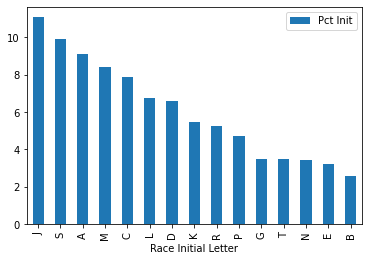

In [35]:
race_names_count = pd.DataFrame(no_dnf_dupes.groupby(['Starts With']).count()['Overall'])
##
race_names_count = race_names_count.sort_values('Overall', ascending=False).reset_index()
print(race_names_count.head())
race_names_count['Grand Total'] = race_names_count['Overall'].sum()
race_names_count.rename(columns={'Overall': 'Sum Names', 'Starts With': 'Race Initial Letter'}, inplace=True)
##less_dnf_sorted.plot.scatter(x='Time', y='Total Characters')
race_names_count['Pct Init'] = 100 * race_names_count['Sum Names'] / race_names_count['Grand Total']
race_names_short = race_names_count.head(15)
race_names_short.plot.bar('Race Initial Letter','Pct Init')

In [38]:
time_correct_df = no_dnf_dupes.astype({'Time per Full': 'timedelta64[m]'})

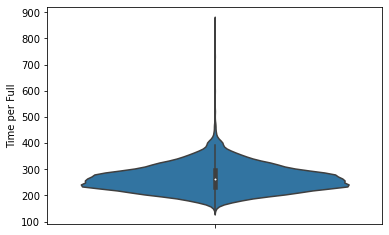

In [47]:
sns.violinplot(y='Time per Full', data=time_correct_df)

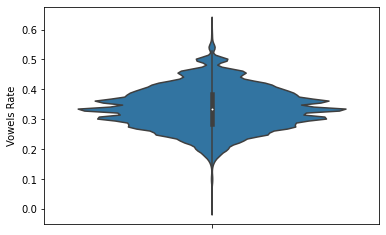

In [48]:
sns.violinplot(y='Vowels Rate', data=time_correct_df)

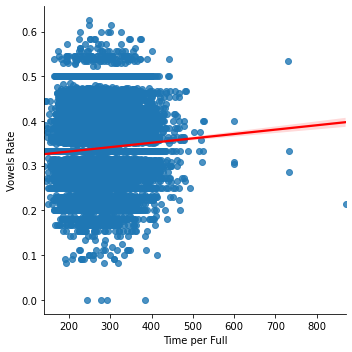

In [45]:
sns.lmplot(x='Time per Full', y='Vowels Rate', data=time_correct_df, line_kws={'color': 'red'})

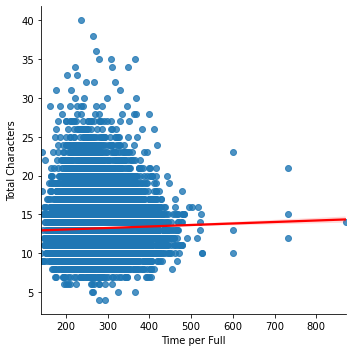

In [46]:
sns.lmplot(x='Time per Full', y='Total Characters', data=time_correct_df, line_kws={'color': 'red'})

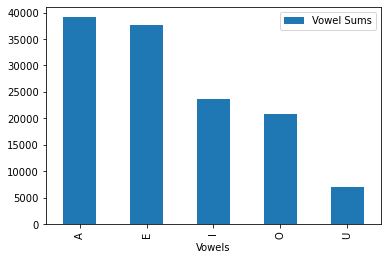

In [41]:
sum_vowels = [time_correct_df['A Count'].sum(), time_correct_df['E Count'].sum(), time_correct_df['I Count'].sum(), time_correct_df['O Count'].sum(), time_correct_df['U Count'].sum()]
new_df = pd.DataFrame({'Vowel Sums': sum_vowels, 'Vowels': ['A', 'E', 'I', 'O', 'U']})
new_df.plot.bar('Vowels','Vowel Sums')